In [360]:
import os
import re
import json
import glob
import string
import operator
import datetime
from collections import Counter
import itertools
import pandas as pd
import numpy as np

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import IPython.display
from IPython.display import display
# plt.rc('font', serif='Times New Roman', family='serif', size=12.0)

# Word processing

In [113]:
pg_stopwords_filepath = '/usr/local/Cellar/postgresql/9.6.1/share/postgresql/tsearch_data/english.stop'
pg_stopwords = set(line.strip() for line in open(pg_stopwords_filepath))
print '|pg_stopwords| =', len(pg_stopwords)

|pg_stopwords| = 127


In [112]:
nltk_stopwords_filepath = os.path.expanduser('~/nltk_data/corpora/stopwords/english')
nltk_stopwords = set(line.strip() for line in open(nltk_stopwords_filepath))
print '|nltk_stopwords| =', len(nltk_stopwords)

|nltk_stopwords| = 153


In [109]:
google_1t_stopwords = set(line.strip() for line in open('google-1t.txt'))
print '|google_1t_stopwords| =', len(google_1t_stopwords)

|google_1t_stopwords| = 193


In [110]:
alphabet = set(string.ascii_lowercase)
print '|alphabet| =', len(alphabet)

|alphabet| = 26


In [493]:
contraction_suffixes = set(['s', 'm', 're', 've', 'll', 'd', 't'])
contraction_prefixes = set(['don', 'isn'])

In [494]:
standard_stopwords = google_1t_stopwords | contraction_suffixes | contraction_prefixes

In [852]:
def tokenize(s, stopwords=None):
    # normalize abbreviations to avoid stranded initials
    s = re.sub(r'(?:[A-Z]\.)+', lambda m: m.group(0).replace('.', ''), s)
    # normalize numbers to avoid 000 turning up as a significant token
    s = re.sub(r',(\d{3})\b', r'\1', s)
    # leave out non-linguistic content
    s = re.sub(r'\[(applause|crosstalk|laughter|inaudible|silence|booing|boos)\]', ' ', s, re.I)
    # replace all non-alphanumerics with spaces
    s = re.sub(r'[^\w]', ' ', s)
    for token in s.lower().strip().split():
        if stopwords is None or token not in stopwords:
            yield token

In [200]:
def speeches_to_counts(speeches, stopwords=None):
    tokens = [token for speech in speeches for token in tokenize(speech['text'], stopwords)]
    return Counter(tokens)

In [201]:
def normalize_counts(counts, smoothing=0.0):
    total = float(sum(counts.values()))
    return {k: (v + smoothing) / total for k, v in counts.items()}

In [585]:
def read_lines(filepaths):
    for filepath in filepaths:
        with open(filepath) as fp:
            for line in fp:
                yield line

In [592]:
def google_1t_frequencies(tokens):
    '''
    Assuming tokens are lower-case.
    '''
    remaining_tokens = set(tokens)
    google_1t_filepath_lower = os.path.expanduser(
        '~/corpora-public/Google-1T-unigrams-only/derivatives/vocab_cs_lower')
    with open(google_1t_filepath_lower) as fp:
        for line in fp:
            token, count_string = line.decode('utf-8').split('\t')
            if token in remaining_tokens:
                remaining_tokens.remove(token)
                yield token, float(count_string) / 1024908267229.0
            if len(remaining_tokens) == 0:
                # exit as soon as we're done
                break

## Speech loading

In [302]:
def read_inaugural():
    for line in read_lines(['../data/tapp/inaugurals.json']):
        yield json.loads(line)

In [140]:
pretrump_inaugural_counts = speeches_to_counts(speech for speech in read_inaugural() 
                                               if 'Trump' not in speech['author'])
print '# tokens:', sum(pretrump_inaugural_counts.values())

# tokens: 134797


In [141]:
# prewar_inaugural_counts = speeches_to_counts(speech for speech in read_inaugural() 
#                                              if speech['timestamp'] < '1948-11-01')
# print '# tokens:', sum(prewar_inaugural_counts.values())

In [142]:
postwar_pretrump_inaugural_counts = speeches_to_counts(speech for speech in read_inaugural() 
                                                       if speech['timestamp'] > '1948-11-01' 
                                                       and 'Trump' not in speech['author'])
print '# tokens:', sum(postwar_pretrump_inaugural_counts.values())
# print 'top 50 types:', postwar_pretrump_inaugural_counts.most_common(50)

# tokens: 33938


In [143]:
def read_election2016_speeches():
    for line in read_lines(['../data/tapp/election2016.json']):
        speech = json.loads(line)
        title = speech['title']
        if 'Press Release' not in title and 'Statement by' not in title:
            yield speech

In [145]:
trump_election2016_counts = speeches_to_counts(speech for speech in read_election2016_speeches()
                                               if speech['author'] == 'Donald J. Trump')
print '# tokens:', sum(trump_election2016_counts.values())
# print 'top 50 types:', trump_election2016_counts.most_common(50)

# tokens: 163681


# Proportion of speech allocated to specific word groups

In [900]:
synsets = [
    ('freedom(s)', ['freedom', 'freedoms']),
    #('justice', ['justice']),
    ('liberty(ies)', ['liberty', 'liberties']),
    #('freedom(s)+\nliberty(ies)', ['freedom', 'freedoms', 'liberty', 'liberties']),
    ('rights', ['rights']),
    #('right(s)', ['right', 'rights']),
    ('america(n(s))', ['america', 'american', 'americans']),
    ('job(s)', ['job', 'jobs']),
    ('peace(ful)', ['peace', 'peaceful']),
    #('constitution', ['constitution']),
    #('principle(s/d)', ['principle', 'principles', 'principled']),
    ('immigrate(ion)', ['immigrate', 'immigrates', 'immigrated', 'immigrating', 'immigration']),
    #('russia/ussr', ['russia', 'ussr']),
    #('china', ['china']),
    ('great(er/est)', ['great', 'greater', 'greatest']),
]

In [901]:
def proportional_usage(tokens, counts):
    maximum = sum(counts.values())
    usage = sum(counts.get(token, 0) for token in tokens)
    return float(usage) / float(maximum)

def synset_proportional_usages(synsets, counts):
    return {synset_name: proportional_usage(synset_tokens, counts) for synset_name, synset_tokens in synsets}

In [902]:
def iter_usages():
    sources = [('All pre-Trump inaugural speeches', pretrump_inaugural_counts),
               #('Pre-war inaugural speeches', prewar_inaugural_counts),
               ('Post-war, pre-Trump inaugural speeches', postwar_pretrump_inaugural_counts),
               ('Trump campaign speeches', trump_election2016_counts)]
    for source_name, source_counts in sources:
        for synset_name, synset_tokens in synsets:
            usage = proportional_usage(synset_tokens, source_counts)
            yield dict(source=source_name, synset=synset_name, usage=usage)

In [903]:
df_usages = pd.DataFrame.from_dict(iter_usages())

In [904]:
df_usages_t = df_usages.pivot(index='synset', columns='source', values='usage')
df_usages_t

source,All pre-Trump inaugural speeches,"Post-war, pre-Trump inaugural speeches",Trump campaign speeches
synset,,,
america(n(s)),0.007271,0.007838,0.022673
freedom(s),0.003275,0.003683,0.000286
great(er/est),0.007339,0.003094,0.006371
immigrate(ion),0.000086,0.000000,0.002660
job(s),0.000223,0.000354,0.010081
liberty(ies),0.002315,0.001355,0.000177
peace(ful),0.004819,0.003182,0.000764
rights,0.002366,0.000648,0.000327


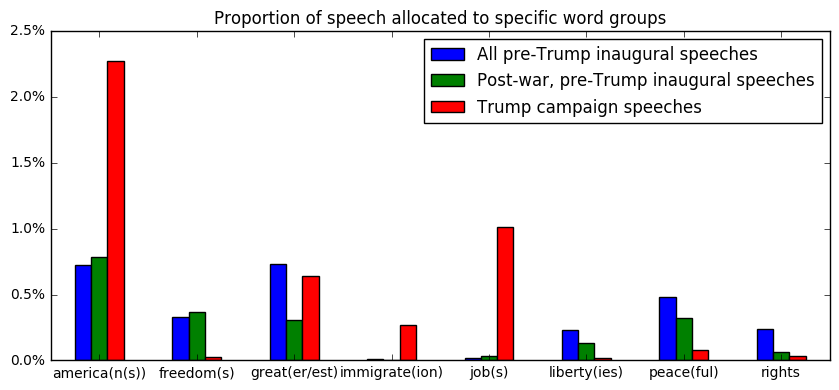

In [905]:
ax = df_usages_t.plot(figsize=(8.5, 4), kind='bar')
ax.xaxis.label.set_visible(False)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.01%}'.format(y))) 
legend = ax.legend()
legend.set_title(None)
plt.xticks(rotation=0)
plt.title('Proportion of speech allocated to specific word groups')
plt.tight_layout()
# plt.savefig('grouped_proportions.nostopwords.pdf')

# Inaugural address word count

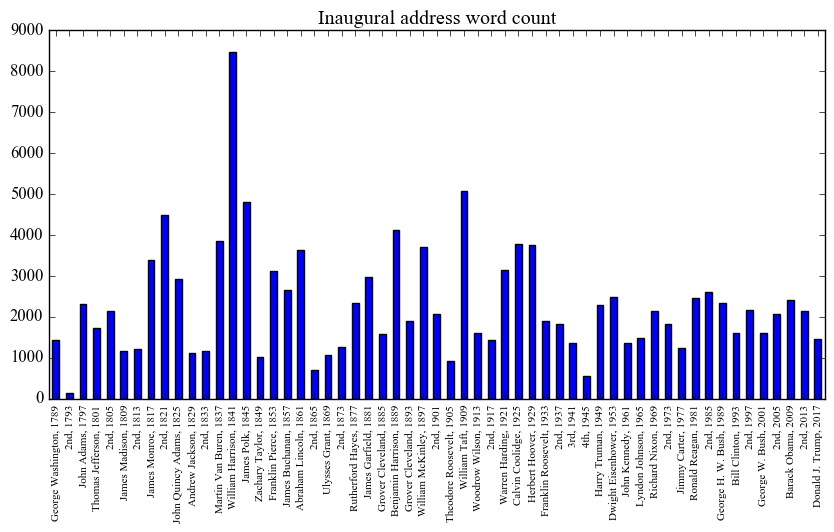

In [680]:
ordinal_mapping = {'First': '1st', 'Second': '2nd', 'Third': '3rd', 'Fourth': '4th'}
def get_inaugural_ticklabels(df):
    last_author = None
    for _, speech in df.iterrows():
        author = speech.author
        title = ordinal_mapping[speech.title.split()[0]] if author == last_author else author
        last_author = author
        yield title + ', ' + str(speech.timestamp.year)
# draw plot for all inaugurals
ax = df.plot(x='timestamp', y='word_count', figsize=(8.5, 5.5), kind='bar', legend=False, 
             title="Inaugural address word count")
ticklabels = list(get_inaugural_ticklabels(df))
for label in ax.get_xticklabels():
    label.set_fontsize(8)
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.xaxis.label.set_visible(False)
plt.tight_layout()
# plt.savefig('inaugural_word_count.pdf')

# Surname mentions in inaugural speeches

In [764]:
pd.options.display.max_rows = 7
pd.options.display.max_columns = 7

In [765]:
def iter_surnames(speeches, surnames):
    for speech in speeches:
        text = speech['text']
        title = speech['author'] + ': ' + speech['title']
        for surname in surnames:
            surname_count = text.count(surname)
            yield dict(title=title, surname=surname, count=surname_count)

In [772]:
speeches = list(read_inaugural())
surnames_list = [speech['author'].split()[-1] for speech in speeches]
surnames = set(surnames_list)

In [782]:
titles_ordered = [speech['author'] + ': ' + speech['title'] for speech in speeches]
surnames_ordered = sorted(list(surnames), key=surnames_list.index)

In [779]:
df_surnames = pd.DataFrame.from_dict(iter_surnames(speeches, surnames))
df_surnames

,count,surname,title
0,0,Wilson,George Washington: Inaugural Address
1,0,Jackson,George Washington: Inaugural Address
2,0,Buren,George Washington: Inaugural Address
...,...,...,...
2027,0,Truman,Donald J. Trump: Inaugural Address
2028,0,Polk,Donald J. Trump: Inaugural Address
2029,0,Monroe,Donald J. Trump: Inaugural Address


In [783]:
df_xtab = df_surnames.pivot(index='title', columns='surname', values='count')
# reorder columns
df_xtab = df_xtab[surnames_ordered]
# reorder rows
df_xtab = df_xtab.reindex(titles_ordered)
df_xtab

surname,Washington,Adams,Jefferson,...,Clinton,Obama,Trump
title,,,,,,,
George Washington: Inaugural Address,0,0,0,...,0,0,0
George Washington: Second Inaugural Address,0,0,0,...,0,0,0
John Adams: Inaugural Address,0,0,0,...,0,0,0
...,...,...,...,...,...,...,...
Barack Obama: Inaugural Address,0,0,0,...,0,0,0
Barack Obama: Second Inaugural Address,0,0,0,...,0,0,0
Donald J. Trump: Inaugural Address,2,0,0,...,1,3,0


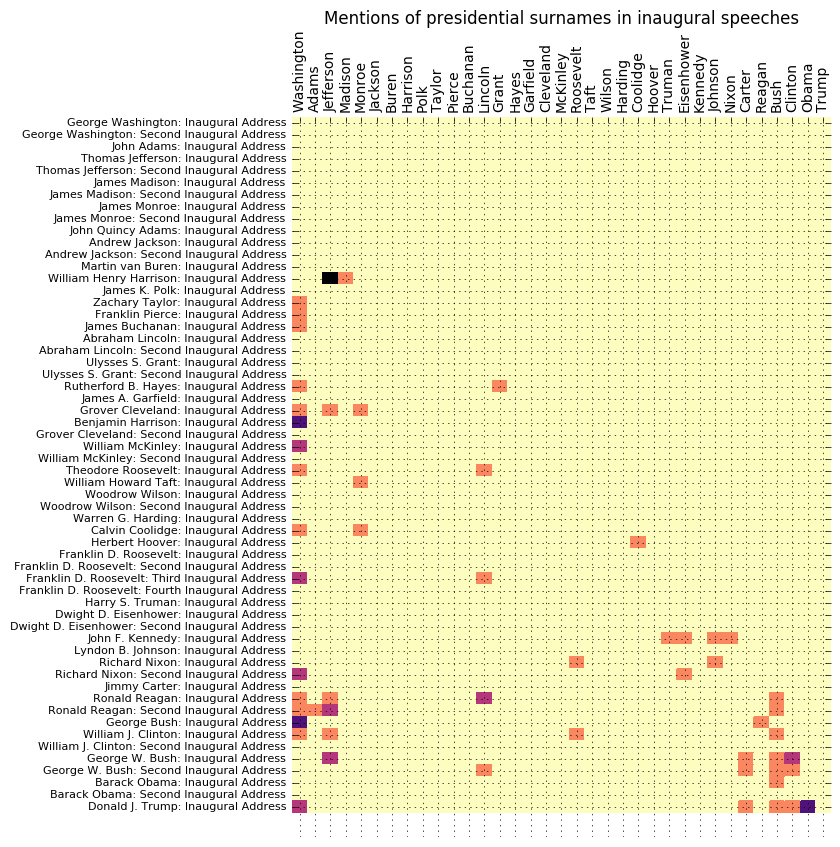

In [786]:
# based on https://stackoverflow.com/a/16124677
plt.figure(figsize=(8.5, 8.5))
plt.pcolor(df_xtab, cmap=plt.cm.magma_r)
ax = plt.axes()
ax.set_frame_on(False)
ax.set_yticks(np.arange(df_xtab.shape[0]) + 0.5, minor=False)
ax.set_xticks(np.arange(df_xtab.shape[1]) + 0.5, minor=False)
# flip x-ticks/labels to top
ax.invert_yaxis()
ax.xaxis.set_ticks_position('top')
# ax.xaxis.tick_top()
plt.xticks(rotation=90)
# set the x/y tick labels
ax.set_xticklabels(df_xtab.columns, minor=False)
ax.set_yticklabels(df_xtab.index, minor=False)
ax.grid(True)
# better label fit
for label in ax.get_yticklabels():
    label.set_fontsize(8)
plt.title('Mentions of presidential surnames in inaugural speeches', y=1.12)
plt.tight_layout()
# plt.savefig('inaugural_surnames.pdf')

# Self mentions in speeches


# Significant others

In [858]:
def iter_counts(groups, vocab, smoothing=0):
    '''
    groups: a list of (group_name, group_counts) pairs
    vocab: a set/list of tokens
    '''
    for group_name, group_counts in groups:
        for word in vocab:
            yield dict(group=group_name, word=word, word_count=group_counts.get(word, 0) + smoothing)

In [859]:
def set_proportion(df):
    '''
    This seems ugly as the argument to pd.GroupedDataSeries.apply(), but it works
    '''
    df['proportion'] = df['word_count'] / np.sum(df['word_count'])
    return df

In [860]:
pd.options.display.max_columns = 10
pd.options.display.max_rows = 10

In [861]:
# postwar pre-trump
# inaugural_counts = speeches_to_counts(
#     (speech for speech in read_inaugural() 
#      if speech['timestamp'] > '1948-11-01' 
#      and 'Trump' not in speech['author']), standard_stopwords)
# all pre-trump
inaugural_counts = speeches_to_counts(
    (speech for speech in read_inaugural() 
     if 'Trump' not in speech['author']), standard_stopwords)
print '|inaugural_counts| =', sum(inaugural_counts.values())

|inaugural_counts| = 58308


In [862]:
trump_election2016_counts = speeches_to_counts(
    (speech for speech in read_election2016_speeches()
     if speech['author'] == 'Donald J. Trump'), standard_stopwords)
print '|tokens| =', sum(trump_election2016_counts.values())

|tokens| = 73304


In [863]:
groups = [('inaugural', inaugural_counts),
          ('trump', trump_election2016_counts)]

In [864]:
full_vocab = set([token for _, counts in groups for token in counts.keys()]) # 12219
print '|full_vocab| =', len(full_vocab)

|full_vocab| = 12272


In [866]:
k = 250
smoothing = 5.0

In [867]:
df_counts = pd.DataFrame.from_dict(iter_counts(groups, full_vocab, smoothing)).groupby('group').apply(set_proportion)
# df_counts

In [868]:
# derive more condensed vocabulary
df_proportions_merged = df_counts.groupby('word').agg({'proportion': sum})
# df_proportions_merged.sort_values('proportion', ascending=False)

In [869]:
vocab = set(df_proportions_merged.nlargest(k, 'proportion').index)
print '|vocab| =', len(vocab)

|vocab| = 250


In [870]:
print ' '.join(vocab)

remember office less money executive years bring including human love children increase police thank justice workers percent education crime better failed stand nor win policy women thousands strength hope build pay family good government far big safe stop nation cannot know words communities world trade emails nearly school necessary like lost countries schools always seek taxes across deals bad common small done security secretary borders right old deal people doing national principles past donald economic election year happen ourselves best said constitution federal god radical liberty business state energy safety obamacare between progress public themselves cost million jobs power whose men free job china others ask november cities respect change care faith great defense working freedom dollars citizens days against foreign american place massive action military poverty whole think first duty clinton secure campaign political washington number community two down americans another v

In [871]:
# could take a second depending on how rare the vocab is
# vocab_1t_frequencies = dict(google_1t_frequencies(vocab))

In [872]:
# recount with condensed vocab
df_counts = pd.DataFrame.from_dict(iter_counts(groups, vocab, smoothing)).groupby('group').apply(set_proportion)
# df_counts.sort_values('proportion', ascending=False)

### Oh boy word clouds

In [822]:
from wordcloud import WordCloud

In [728]:
def display_frequencies_wordcloud(frequencies):
    #wordCloud = WordCloud(max_font_size=40)
    wordCloud = WordCloud()
    wordCloud_generated = wordCloud.generate_from_frequencies(frequencies)
    plt.imshow(wordCloud_generated)
    plt.axis('off')

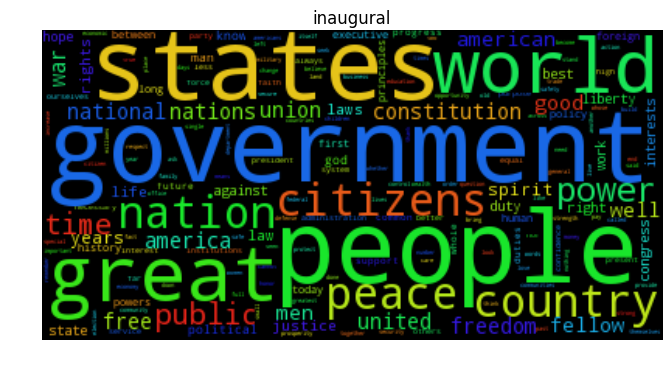

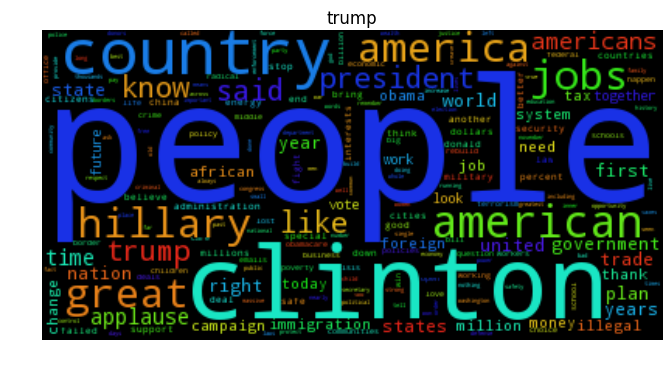

In [729]:
for group, group_df in df_counts.groupby('group'):
    plt.figure(figsize=(8.5, 4))
    display_frequencies_wordcloud(zip(group_df.word, group_df.proportion))    
    plt.title(group)

### Back to business

In [960]:
df_proportions = df_counts.pivot(index='word', columns='group', values='proportion')

In [975]:
df_proportions['trump/inaugural'] = df_proportions.trump / df_proportions.inaugural
#rad = np.arctan(df_proportions['trump/inaugural']) 
rad = np.arctan2(df_proportions.trump, df_proportions.inaugural)
# re-map from [0, pi/2] to [-1, 1]
df_proportions[u'trump°inaugural'] = rad * (4.0 / np.pi) + -1.0

In [1072]:
# equal bin widths:
# _, binedges = np.histogram(df_proportions[u'trump°inaugural'], bins=7)
# equal bin depths:
binedges = np.percentile(df_proportions[u'trump°inaugural'], np.linspace(0, 100, 8))

In [1073]:
binnames = ['Most presidential', '2nd-most presidential', '3rd-most presidential',
            'Neutral', 
            '3rd-most Trumpy', '2nd-most Trumpy', 'Most Trumpy']
assignments = np.digitize(df_proportions[u'trump°inaugural'], binedges[:-1]) - 1
df_proportions['trumpiness'] = np.array(binnames)[assignments]

In [1074]:
# df_proportions['google_1t'] = df_proportions.index.map(lambda k: vocab_1t_frequencies.get(k, 1))

In [1091]:
pd.options.display.max_rows = 50

In [1092]:
df_proportions.sort_values('trump/inaugural')

group,inaugural,trump,trump/inaugural,trump°inaugural,trumpiness
word,,,,,
union,0.010323,0.000257,0.024943,-0.968249,Most presidential
duties,0.005188,0.000193,0.037221,-0.952631,Most presidential
progress,0.005295,0.000225,0.042547,-0.945860,Most presidential
nor,0.004921,0.000257,0.052325,-0.933438,Most presidential
fellow,0.008291,0.000515,0.062115,-0.921014,Most presidential
confidence,0.004921,0.000354,0.071947,-0.908552,Most presidential
freedom,0.010430,0.000772,0.074060,-0.905876,Most presidential
nations,0.010751,0.000805,0.074843,-0.904884,Most presidential
principles,0.005402,0.000418,0.077451,-0.901582,Most presidential


In [1093]:
trumpiness_bins = [(name, pd.Series(list(group_df.sort_values(u'trump°inaugural', ascending=True).word)))
                   for name, group_df in df_proportions.reset_index().groupby('trumpiness')]

In [1094]:
df_bins = pd.DataFrame(dict(trumpiness_bins)).fillna('')
df_bins = df_bins[binnames]
df_bins

,Most presidential,2nd-most presidential,3rd-most presidential,Neutral,3rd-most Trumpy,2nd-most Trumpy,Most Trumpy
0,union,action,states,support,care,like,deal
1,duties,public,long,lives,seen,choice,plan
2,progress,man,become,people,election,money,workers
3,nor,government,world,business,another,think,massive
4,fellow,war,against,wealth,left,down,job
5,confidence,whose,old,times,education,trade,happen
6,freedom,laws,whether,future,country,schools,school
7,nations,justice,respect,today,build,safe,november
8,principles,seek,good,administration,america,special,police
9,ourselves,high,opportunity,better,women,american,illegal


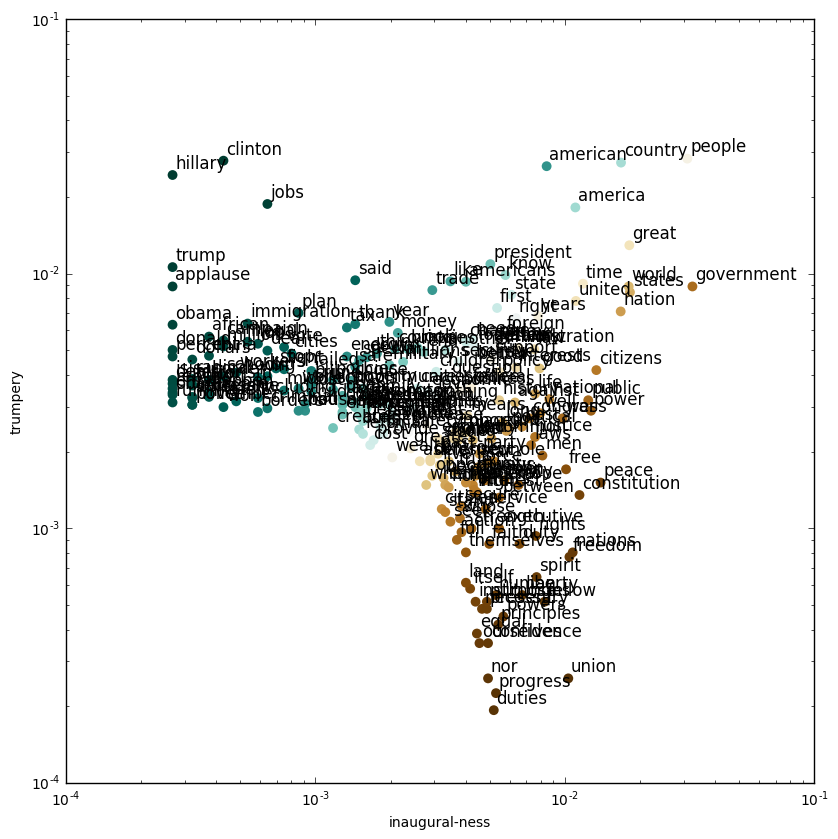

In [969]:
plt.figure(figsize=(8.5, 8.5))
# x
x = df_proportions['inaugural']
plt.xscale('log')
# plt.xlabel('global frequency of word (based on Google 1T unigrams)')
plt.xlabel('inaugural-ness')
# y
y = df_proportions['trump']
plt.yscale('log')
# plt.ylabel(u'relative\n<- inauguralness or Trumpery ->')
plt.ylabel('trumpery')
# points
plt.scatter(x, y, c=df_proportions[u'trump°inaugural'], cmap=plt.cm.BrBG, linewidths=0, s=50)
for label, x, y in zip(df_proportions.index, x, y):
    plt.annotate(label, xy=(x, y), xytext=(2, 2),
                 size='large',
                 textcoords='offset points', ha='left', va='bottom')
plt.tight_layout()
# plt.savefig('relative_trumpery_scatter_100.pdf')